In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=0f5473318935b564200be785ffe8038b6c0b97d7b97b3732005aa58763e028d2
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [ ]:
#Import Libraries
from __future__ import print_function, division
import os
import cv2
from PIL import Image
import pdb
import time
import copy
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
#Albumentation
from albumentations import (HorizontalFlip,VerticalFlip,CenterCrop, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
#import segmentation_models_pytorch as smp
from pathlib import Path
from sklearn.metrics import recall_score,f1_score
import gc
warnings.filterwarnings("ignore")
#Seed
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from efficientnet_pytorch import EfficientNet
#from cutmix.cutmix import CutMix
#from cutmix.utils import CutMixCrossEntropyLoss

In [ ]:
#Data Download
!wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589025205&Signature=s1fFKr9sm8QZbbAA%2BHWX%2BNEKuaXAUWTfGfqVOBL5HeDUGgUk1LRQZbVgRHNYdCh7hQZz4pVoogNvYt5vyarW9dErmOtfPuS4ZtIaQ3V0zmKPDcUtxLXBcV4LSvTgyrTaVgatbe9IvCucurMERiG3A0S4jnTEVw5cD3J4UzHiw51EUJYuzYBU2DInO3ycribthfi7hkAD6Jd7tPyo6No8emj%2FH8zZRsUME4lmpyo9Oe55cfLZleeKJClYzj8w3UcC64cymnxub4Dafmdbx02wPz5mHbMkqW8zv%2BpA%2FLbskXVEjcrvDqC4pb4Y%2FCEcXjCuoPkVDXdYCwWXu%2FUjlOCvGQ%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip"

The name is too long, 534 chars total.
Trying to shorten...
New name is archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589025205&Signature=s1fFKr9sm8QZbbAA+HWX+NEKuaXAUWTfGfqVOBL5HeDUGgUk1LRQZbVgRHNYdCh7hQZz4pVoogNvYt5vyarW9dErmOtfPuS4ZtIaQ3V0zmKPDcUtxLXBcV4LSvTgyrTaVgatb.
--2020-05-07 11:37:36--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589025205&Signature=s1fFKr9sm8QZbbAA%2BHWX%2BNEKuaXAUWTfGfqVOBL5HeDUGgUk1LRQZbVgRHNYdCh7hQZz4pVoogNvYt5vyarW9dErmOtfPuS4ZtIaQ3V0zmKPDcUtxLXBcV4LSvTgyrTaVgatbe9IvCucurMERiG3A0S4jnTEVw5cD3J4UzHiw51EUJYuzYBU2DInO3ycribthfi7hkAD6Jd7tPyo6No8emj%2FH8zZRsUME4lmpyo9Oe55cfLZleeKJClYzj8w3UcC64cymnxub4Dafmdbx02wPz5mHbMkqW8zv%2BpA%2FLbskXVEjcrvDqC4pb4Y%2FCEcXjCuoPkVDXdYCwWXu%2FUjlOCvGQ%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip
Resolving storage.googleapis.co

In [ ]:
#Rename and extract
!unzip "/content/data.zip"

In [ ]:
import pandas as pd
train = pd.read_csv('/content/labels.csv')
train.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


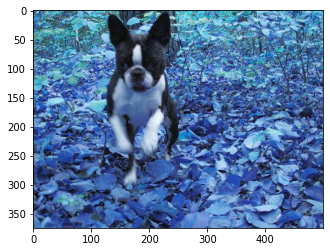

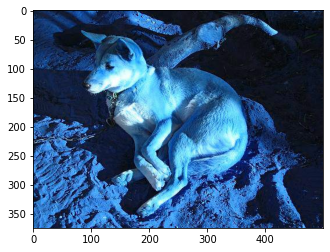

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(2):
  img = cv2.imread('/content/train/'+str(train["id"][i])+'.jpg')
  
  plt.imshow(img)
  plt.figure()

In [ ]:
train["breed"].value_counts(normalize=True)

scottish_deerhound      0.012326
maltese_dog             0.011446
afghan_hound            0.011348
entlebucher             0.011250
bernese_mountain_dog    0.011152
                          ...   
golden_retriever        0.006554
komondor                0.006554
brabancon_griffon       0.006554
briard                  0.006457
eskimo_dog              0.006457
Name: breed, Length: 120, dtype: float64

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=120)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
##Class weights
df = pd.read_csv('/content/labels.csv')
df.head()
x = df["breed"].value_counts()
class_wts = [0]*120
for i in range(len(x)):
    class_wts[i]=x.values[i]
maxi = max(class_wts)
for i in range(len(class_wts)):
    class_wts[i]=np.exp(-class_wts[i]/maxi)
class_wts = torch.Tensor(class_wts)
device = torch.device("cuda")
class_wts = class_wts.to(device)

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):

        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.transforms2 = get_transforms2(mean, std)
        self.fnames = self.df.index

    def __getitem__(self, idx):

        image_id = self.df["id"].iloc[idx]+'.jpg'
        image_path = os.path.join(self.root,  image_id)
        img = cv2.imread(image_path)
        img = cv2.resize(img,(256,256))
        label = np.asarray(self.df.iloc[idx].iloc[1:]).astype(np.uint8)
        augmented = self.transforms(image=img)
        imgtf1 = augmented['image']
        aug = self.transforms2(image = img)
        imgtf2 = aug["image"]
        return imgtf1,imgtf2,label

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend(
                  [GaussNoise(p=0.5),
                   RandomBrightnessContrast(p=1),
                   RandomCrop(30,30,p=0.5),
                   CenterCrop(30,30,p=0.5),
                   HorizontalFlip(),
                   ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=2, border_mode=1, p=1),
                   ]
        )
    list_transforms.extend(
        [ 
            Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def get_transforms2( mean, std):
    list_transforms = []
    list_transforms.extend(
        [ 
            
            Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def crop_char_image3(image, threshold=80):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    data = pd.read_csv(df_path)
    label = data['breed']
    data2 = pd.get_dummies(label)

    data=data.drop(columns=['breed'])
    data=pd.concat([data,data2],axis=1)

    train_df, val_df = train_test_split(data, test_size=0.2,stratify=label)
    df = train_df if phase == "train" else val_df
    image_dataset = Dataset(df, data_folder, mean, std, phase)

    dataloader = DataLoader(
        #dataset,
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=False,
        shuffle=True,   
    )
    return dataloader

In [ ]:
bs = 16
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probs, t, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(t)
    with torch.no_grad():
        t = (t ).float().cpu()
        pt = probs.argmax(dim=1)
        tt = t.argmax(dim=1)
        csum = (pt==tt).sum().float()
        acc  = csum/bs
        f1_sc = f1_score(tt,pt,average='weighted')*100

    return acc,f1_sc

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.phase = phase
        self.accuracy = []
        self.f1 = []

    def update(self, targets, outputs):
        acc,f1_sc = metric(outputs, targets, self.base_threshold)
        self.accuracy.append(acc)
        self.f1.append(f1_sc)

    def get_metrics(self):
        acc = np.mean(self.accuracy)
        f1 = np.mean(self.f1)
        return acc,f1

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    acc,f1 = meter.get_metrics()
    print("Loss: %0.4f  | acc: %0.4f  | 100*f1_score: %0.4f " % (epoch_loss, acc, f1))
    return acc,f1

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


In [ ]:
 class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model,num_epochs=20):
        self.num_workers = 0
        self.batch_size = {"train": 16, "val": 16}
        self.accumulation_steps = 1
        self.lr = 3e-3
        self.num_epochs = num_epochs
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss(weight=class_wts)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        
        self.scheduler = ReduceLROnPlateau(self.optimizer,factor=0.33, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.acc_scores = {phase: [] for phase in self.phases}
        self.f1_scores = {phase: [] for phase in self.phases}
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        masks = masks.float()
        outputs = self.net(images)
        loss = self.criterion(outputs,masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()

        for itr, batch in enumerate(tk0):
                   
            img1, img2, targets = batch
            loss, outputs = self.forward(img1, targets)
            loss2, outputs2 = self.forward(img2, targets)
            loss = (loss+loss2)/2
            outputs = (outputs+outputs2)/2
            
            loss = loss / self.accumulation_steps

            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        acc,f1 = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.acc_scores[phase].append(acc)
        self.f1_scores[phase].append(f1)
        torch.cuda.empty_cache()
        return epoch_loss
    def start2(self):
        for epoch in range(self.num_epochs):
            
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
    def start(self): 
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "/content/dogbreed.pth")
            print()

In [ ]:
train_df_path = '/content/labels.csv'
data_folder = "/content/train/"

In [ ]:
device = torch.device("cuda")
model.to(device)

1

In [ ]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 18:06:54



Loss: 0.0263  | acc: 0.0457  | 100*f1_score: 3.7229 
Starting epoch: 0 | phase: val | ⏰: 18:09:24



Loss: 0.0227  | acc: 0.1377  | 100*f1_score: 12.5625 
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 18:09:39



Loss: 0.0209  | acc: 0.1531  | 100*f1_score: 14.5544 
Starting epoch: 1 | phase: val | ⏰: 18:12:07



Loss: 0.0162  | acc: 0.2896  | 100*f1_score: 27.6814 
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 18:12:22



Loss: 0.0195  | acc: 0.2419  | 100*f1_score: 23.7919 
Starting epoch: 2 | phase: val | ⏰: 18:14:50



Loss: 0.0172  | acc: 0.3213  | 100*f1_score: 31.0964 

Starting epoch: 3 | phase: train | ⏰: 18:15:05



Loss: 0.0186  | acc: 0.3091  | 100*f1_score: 30.7554 
Starting epoch: 3 | phase: val | ⏰: 18:17:35



Loss: 0.0191  | acc: 0.3784  | 100*f1_score: 37.1581 

Starting epoch: 4 | phase: train | ⏰: 18:17:50



Loss: 0.0179  | acc: 0.3629  | 100*f1_score: 36.2431 
Starting epoch: 4 | phase: val | ⏰: 18:20:22



Loss: 0.0153  | acc: 0.4175  | 100*f1_score: 41.1289 
******** New optimal found, saving state ********

Starting epoch: 5 | phase: train | ⏰: 18:20:37



Loss: 0.0174  | acc: 0.3998  | 100*f1_score: 39.9552 
Starting epoch: 5 | phase: val | ⏰: 18:23:08



Loss: 0.0114  | acc: 0.5034  | 100*f1_score: 49.7442 
******** New optimal found, saving state ********

Starting epoch: 6 | phase: train | ⏰: 18:23:23



Loss: 0.0168  | acc: 0.4569  | 100*f1_score: 45.7393 
Starting epoch: 6 | phase: val | ⏰: 18:25:52



Loss: 0.0146  | acc: 0.4849  | 100*f1_score: 47.8215 

Starting epoch: 7 | phase: train | ⏰: 18:26:07



Loss: 0.0165  | acc: 0.4852  | 100*f1_score: 48.8066 
Starting epoch: 7 | phase: val | ⏰: 18:28:36



Loss: 0.0131  | acc: 0.5039  | 100*f1_score: 49.5631 

Starting epoch: 8 | phase: train | ⏰: 18:28:51



Loss: 0.0159  | acc: 0.5311  | 100*f1_score: 53.3729 
Starting epoch: 8 | phase: val | ⏰: 18:31:19



Loss: 0.0105  | acc: 0.5732  | 100*f1_score: 56.9486 
******** New optimal found, saving state ********

Starting epoch: 9 | phase: train | ⏰: 18:31:34



Loss: 0.0156  | acc: 0.5602  | 100*f1_score: 56.3826 
Starting epoch: 9 | phase: val | ⏰: 18:34:03



Loss: 0.0105  | acc: 0.5679  | 100*f1_score: 56.3517 

Starting epoch: 10 | phase: train | ⏰: 18:34:17



Loss: 0.0151  | acc: 0.6113  | 100*f1_score: 61.4071 
Starting epoch: 10 | phase: val | ⏰: 18:36:45



Loss: 0.0125  | acc: 0.5430  | 100*f1_score: 53.8212 

Starting epoch: 11 | phase: train | ⏰: 18:36:59



Loss: 0.0148  | acc: 0.6425  | 100*f1_score: 64.6285 
Starting epoch: 11 | phase: val | ⏰: 18:39:27



Loss: 0.0098  | acc: 0.6147  | 100*f1_score: 61.3596 
******** New optimal found, saving state ********

Starting epoch: 12 | phase: train | ⏰: 18:39:42



Loss: 0.0144  | acc: 0.6821  | 100*f1_score: 68.5339 
Starting epoch: 12 | phase: val | ⏰: 18:42:10



Loss: 0.0084  | acc: 0.6733  | 100*f1_score: 66.9611 
******** New optimal found, saving state ********

Starting epoch: 13 | phase: train | ⏰: 18:42:25



Loss: 0.0140  | acc: 0.7181  | 100*f1_score: 72.2021 
Starting epoch: 13 | phase: val | ⏰: 18:44:52



Loss: 0.0083  | acc: 0.6855  | 100*f1_score: 68.3530 
******** New optimal found, saving state ********

Starting epoch: 14 | phase: train | ⏰: 18:45:07



Loss: 0.0137  | acc: 0.7401  | 100*f1_score: 74.6635 
Starting epoch: 14 | phase: val | ⏰: 18:47:35



Loss: 0.0082  | acc: 0.7241  | 100*f1_score: 72.1121 
******** New optimal found, saving state ********

Starting epoch: 15 | phase: train | ⏰: 18:47:50



Loss: 0.0136  | acc: 0.7632  | 100*f1_score: 76.7526 
Starting epoch: 15 | phase: val | ⏰: 18:50:19



Loss: 0.0078  | acc: 0.7290  | 100*f1_score: 72.6459 
******** New optimal found, saving state ********

Starting epoch: 16 | phase: train | ⏰: 18:50:34



Loss: 0.0132  | acc: 0.7941  | 100*f1_score: 79.7668 
Starting epoch: 16 | phase: val | ⏰: 18:53:03



Loss: 0.0069  | acc: 0.7920  | 100*f1_score: 78.9412 
******** New optimal found, saving state ********

Starting epoch: 17 | phase: train | ⏰: 18:53:18



Loss: 0.0129  | acc: 0.8254  | 100*f1_score: 82.9732 
Starting epoch: 17 | phase: val | ⏰: 18:55:47



Loss: 0.0070  | acc: 0.7871  | 100*f1_score: 78.7861 

Starting epoch: 18 | phase: train | ⏰: 18:56:02



Loss: 0.0128  | acc: 0.8318  | 100*f1_score: 83.6682 
Starting epoch: 18 | phase: val | ⏰: 18:58:30



Loss: 0.0074  | acc: 0.7686  | 100*f1_score: 76.9500 

Starting epoch: 19 | phase: train | ⏰: 18:58:45



Loss: 0.0126  | acc: 0.8518  | 100*f1_score: 85.7149 
Starting epoch: 19 | phase: val | ⏰: 19:01:13



Loss: 0.0063  | acc: 0.8008  | 100*f1_score: 79.8130 
******** New optimal found, saving state ********



#PREDICTION

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, data_folder, mean, std):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.transforms = get_transforms(mean, std)
        self.transforms2 = get_transforms2(mean, std)
        self.fnames = self.df.index

    def __getitem__(self, idx):
        #print(self.df.columns)
        image_id = self.df["id"].iloc[idx]+'.jpg'
        image_path = os.path.join(self.root,  image_id)
        img = cv2.imread(image_path)
        img = cv2.resize(img,(256,256))
        augmented = self.transforms(image=img)
        imgtf1 = augmented['image']
        aug = self.transforms2(image = img)
        imgtf2 = aug["image"]
        return imgtf1,imgtf2

    def __len__(self):
        return len(self.fnames)


def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend(
            [GaussNoise(p=0.5),
                   RandomBrightnessContrast(p=1),
                   RandomCrop(30,30,p=0.5),
                   CenterCrop(30,30,p=0.5),
                   HorizontalFlip(),
                   ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=2, border_mode=1, p=1),
                   ]
        )
    list_transforms.extend(
        [ 
            Resize(64,64,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def get_transforms2( mean, std):
    list_transforms = []
    list_transforms.extend(
        [ 
            
            Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def crop_char_image3(image, threshold=80):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def providerx(
    data_folder,
    df_path,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    data = pd.read_csv(df_path)
    test_image_dataset = TestDataset(data, data_folder, mean, std)
    
    dataloader = DataLoader(
        #dataset,
        test_image_dataset,
        batch_size=batch_size,
        shuffle=False,   
    )
    return dataloader 

In [ ]:
model2 = EfficientNet.from_pretrained('efficientnet-b0',num_classes=120)
ckpt_path = "/content/dogbreed.pth"
device = torch.device("cuda")
model2.to(device)
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model2.load_state_dict(state["state_dict"]) 

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [ ]:
from sklearn.preprocessing import normalize
test_data_folder = "/content/test/"
test_df_path = "/content/sample_submission.csv"
data_type = 'test'
batch_size = 32
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
test_preds_list = []
row_id = []
target = []
test_loader = providerx(test_data_folder, test_df_path, mean=mean, std=std, batch_size=16, num_workers=0)
for  i,batch in enumerate(tqdm((test_loader))):
  Class = []
  img1, img2= batch
  b1 = model2(img1.to(device)).detach().cpu().numpy()
  b2 = model2(img2.to(device)).detach().cpu().numpy()
  batch_preds = (b1+b2)/2
  for i in range(len(batch_preds)):
    batch_preds[i]/=np.linalg.norm(batch_preds[i])
    test_preds_list.append(batch_preds[i])
gc.collect()

1072

In [ ]:
for i in range(len(test_preds_list)):
  test_preds_list[i]/=np.mean(test_preds_list[i])
  test_preds_list[i]/=np.linalg.norm(test_preds_list[i])
test_preds_list[8551]

array([ 0.08319765,  0.0966276 ,  0.08569293,  0.07048671,  0.08642   ,
        0.08519144,  0.06869321,  0.04968574,  0.11340402,  0.10548991,
        0.10563456,  0.05338601,  0.12005205,  0.09182875,  0.09730804,
        0.09339693,  0.12220888,  0.07118321,  0.10977279,  0.05140822,
        0.11211357,  0.07610306,  0.04130196,  0.0869611 ,  0.08758298,
        0.12464843,  0.04484252,  0.06168086,  0.09667204, -0.00380516,
        0.0657156 ,  0.08440589,  0.11907507,  0.12295127,  0.1436881 ,
        0.0736658 ,  0.06940451,  0.05010031,  0.08945489,  0.11738877,
        0.12727395,  0.10814298,  0.09482835,  0.05973608,  0.12149653,
        0.03836564,  0.08391957,  0.12356544,  0.12038106,  0.0931608 ,
        0.08136775,  0.09805816,  0.07922523,  0.07029009,  0.03955981,
        0.05574755,  0.07604737,  0.06703749,  0.11123656,  0.07839675,
        0.05109484,  0.1347095 ,  0.04416569,  0.08648078,  0.10500702,
        0.10318632,  0.13415077,  0.10667274,  0.06047772,  0.14

In [ ]:
test_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
for i in range(len(test_df)):
  test_df.iloc[i, 1:] = np.array(test_preds_list[i])

In [ ]:
test_df.to_csv("sub.csv",index=False)

In [ ]:
from google.colab import files
files.download("/content/sub.csv")